In [1]:
import os
import json
import codecs
import numpy as np
from numpy import log, exp
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from scipy.stats import spearmanr, pearsonr, gaussian_kde

In [2]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

def logit(p):
    return log(p) - log(1 - p)

In [3]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class SigmoidFit(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def __call__(self, valid_preacts, valid_labels):
        def loss_func(x):
            new_labels = (x[0]*sigmoid(valid_preacts+x[1]))+x[2]
            return mean_squared_error(new_labels, valid_labels)

        x0 = np.array([1.0, 0.0, 0.0])
        res = minimize(loss_func, x0, method='BFGS', options={'gtol': 1e-9, 'disp': True, 'maxiter': 1000})
        print("multiplier: ",res.x[0],", in sigmoid bias: ",res.x[1],", out of sigmoid bias: ",res.x[2])

        def calibration_func(preact):
            return (res.x[0]*sigmoid(preact+res.x[1]))+res.x[2]

        def inv_func(label):
            return logit((label-res.x[2])/res.x[0])-res.x[1]

        return calibration_func, inv_func

load the data

In [4]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
allFlanks = []
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)
        allFlanks.append(flank)

In [5]:
obj_text1 = codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read()
flankToPho4CountPreds = json.loads(obj_text1)

In [6]:
obj_text2 = codecs.open("data/preds/limited.cbf1.eth.logCounts_fixed_min.json", 'r', encoding='utf-8').read()
flankToCbf1CountPreds = json.loads(obj_text2)

sampling and processing

In [7]:
sampled_valid_keys = np.random.choice(allFlanks, 10000, replace=False)
sampled_keys = np.random.choice(allFlanks, 50000, replace=False)

In [8]:
samplePho4CountPreds = {}
for key in sampled_valid_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4CountPreds[key] = np.mean(y_1-y_0)
for key in sampled_keys:
    y_0 = np.array(flankToPho4CountPreds[key][0]).astype(float)
    y_1 = np.array(flankToPho4CountPreds[key][1]).astype(float)
    samplePho4CountPreds[key] = np.mean(y_1-y_0)

plotting code

In [9]:
%matplotlib inline

def plotCorrs(xvals, yvals, xlabel, ylabel):
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("correlation: "+str(pearsonr(xvals, yvals)))
    plt.show()

-ddG to count  (Pho4 PBexo)

In [10]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(samplePho4CountPreds[key])
    valid_labels.append(-flankToPho4Ddg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [11]:
preacts = []
labels = []
for key in sampled_keys:
    preacts.append(samplePho4CountPreds[key])
    labels.append(-flankToPho4Ddg[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [12]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)

Optimization terminated successfully.
         Current function value: 0.002807
         Iterations: 47
         Function evaluations: 405
         Gradient evaluations: 81
multiplier:  1.3179306087464695 , in sigmoid bias:  -2.2076386898290696 , out of sigmoid bias:  -0.5315839981209008


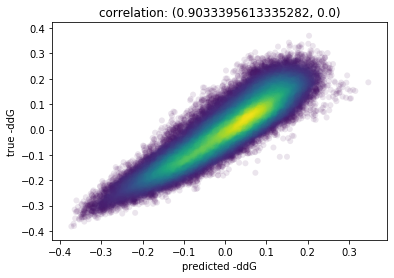

In [13]:
plotCorrs(calibrated_labels, labels, "predicted -ddG", "true -ddG")

In [14]:
calibrated_preacts = inv_func(labels)

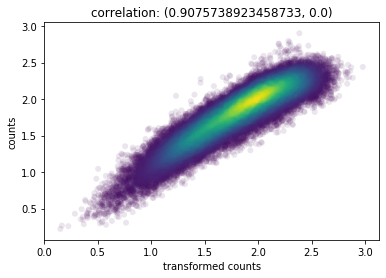

In [15]:
plotCorrs(calibrated_preacts, preacts, "transformed counts", "counts")

-ddG to count  (Cbf1 ChIPexo Ethanol-Limited)

In [16]:
valid_preacts = []
valid_labels = []
for key in sampled_valid_keys:
    valid_preacts.append(float(flankToCbf1CountPreds[key]))
    valid_labels.append(-flankToCbf1Ddg[key])
valid_preacts = np.array(valid_preacts)
valid_labels = np.array(valid_labels)

In [17]:
preacts = []
labels = []
for key in sampled_keys:
    preacts.append(float(flankToCbf1CountPreds[key]))
    labels.append(-flankToCbf1Ddg[key])
preacts = np.array(preacts)
labels = np.array(labels)

In [18]:
sf = SigmoidFit()
calibration_func, inv_func = sf(valid_preacts, valid_labels)
calibrated_labels = calibration_func(preacts)

         Current function value: 0.005272
         Iterations: 47
         Function evaluations: 636
         Gradient evaluations: 125
multiplier:  0.7211923613441191 , in sigmoid bias:  -8.03942042828558 , out of sigmoid bias:  -0.2462284164295161


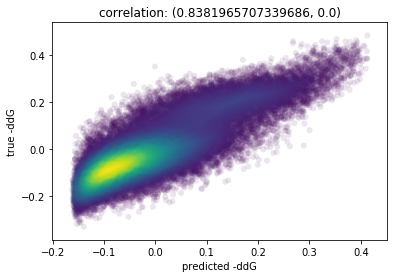

In [19]:
plotCorrs(calibrated_labels, labels, "predicted -ddG", "true -ddG")

In [20]:
calibrated_preacts = inv_func(labels)

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


In [21]:
plotCorrs(calibrated_preacts, preacts, "transformed counts", "counts")

ValueError: array must not contain infs or NaNs